# Tactical Asset Allocation

In [1]:
%%capture
%reload_ext autoreload
%autoreload 2
%cd ..
%cd src

In [59]:
from pytaa.tools.data import get_strategy_price_data
from pytaa.strategy.static import STRATEGIES
from pytaa.strategy.strategies import StrategyPipeline
from pytaa.strategy.signals import Signal
from pytaa.backtest.positions import EqualWeights, RiskParity, vigilant_allocation
from pytaa.backtest.performance import Tearsheet
from pytaa.backtest.returns import Backtester
from pytaa.tools.utils import ledoit_wolf_constant_correlation


import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [60]:
start, end = "2011-01-01", "2023-05-01"
rebalance_dates = pd.bdate_range(start, end, freq="BM")

pipeline = StrategyPipeline(STRATEGIES)
data = get_strategy_price_data(pipeline, start, end).dropna()

In [177]:
all_strategies = []

# ivy
strategy = pipeline.ivy
strategy_data = data[strategy.risk_assets]
signals = Signal(strategy_data).sma_crossover(10).dropna()

weights = signals.apply(lambda x: np.where(x > 0, strategy.weights[0], 0))
weights.loc[:, strategy.safe_assets] = 1 - weights.sum(axis=1)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# benchmark strategies
assets = strategy.get_tickers()
returns = data.pct_change().dropna().loc[:, assets]

ew = EqualWeights(assets, rebalance_dates).weights
rp = RiskParity(assets, rebalance_dates, returns).weights
all_strategies.append([ew, rp])

# robust asset allocation
strategy = pipeline.raab
strategy_data = data[strategy.get_tickers()]
signal_1 = Signal(strategy_data).classic_momentum(end=0).dropna()
signal_2 = Signal(strategy_data).sma_crossover(12, False).dropna()
cond_1 = np.where(signal_1[strategy.risk_assets].gt(signal_1[strategy.safe_assets].values), 1, 0)
cond_2 = np.where(strategy_data.reindex(signal_2.index) > signal_2, 1, 0)[:,:-1]
final_signal = cond_1 + cond_2
cash = np.atleast_2d(len(strategy.risk_assets) - np.sum(final_signal / 2, 1)).T
weights = pd.DataFrame(np.hstack([final_signal, cash]), index=signal_1.index, columns=signal_1.columns)
weights = weights.div(weights.sum(axis=1).values.reshape(-1, 1))
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# vigilant asset allocation g12
strategy = pipeline.vaag12
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score()
weights = pd.concat([x for x in signal.apply(lambda x: vigilant_allocation(x, strategy.risk_assets, strategy.safe_assets), axis=1)])
weights.index = signal.index
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# gem dual momentum
strategy = pipeline.gdm
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).classic_momentum(start=12, end=0)
cond_1, cond_2 = signal["SPY"].ge(signal["BIL"]), signal["SPY"].ge(signal["EFA"])
spy = np.where(cond_1 & cond_2, 1, 0).reshape(-1,1)
efa = np.where(cond_1 & ~cond_2, 1, 0 ).reshape(-1,1)
agg = np.where(~cond_1, 1, 0).reshape(-1,1)
weights = pd.DataFrame(np.hstack([spy, efa, agg]), index=signal.index, columns=["SPY", "EFA", "AGG"])
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# diversified gem dual momentum
strategy = pipeline.dgdm
strategy_data = data[strategy.get_tickers()]
mom_periods = [6, 7, 8, 9, 10, 11, 12]
monthly = strategy_data.resample("BM").last()
spy, agg, efa = np.zeros((monthly.shape[0], 1)), np.zeros((monthly.shape[0], 1)),np.zeros((monthly.shape[0], 1))

for w in mom_periods:
    signal = Signal(strategy_data).classic_momentum(start=w, end=0)
    cond_1, cond_2 = signal["SPY"].ge(signal["AGG"]), signal["SPY"].ge(signal["EFA"])
    spy += np.where(cond_1 & cond_2, 1, 0).reshape(-1,1)
    efa += np.where(cond_1 & ~cond_2, 1, 0 ).reshape(-1,1)
    agg += np.where(~cond_1, 1, 0).reshape(-1,1)

weights = pd.DataFrame(np.hstack([spy, efa, agg]) / len(mom_periods), index=monthly.index, columns=monthly.columns)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# concat all strats
all_strategies = reduce(lambda x, y: x.join(y, how="outer"), all_strategies).fillna(0)

In [178]:
bt = Backtester(all_strategies, "USD")
port_total_returns = bt.run(return_type="total")
port_total_returns.add(1).cumprod().tail()

,IVY,EW,RP,RAAB,VAAG12,GDM,DGDM
Date,,,,,,,
2022-12-30,1.590742,1.488830,1.094620,1.479556,2.131866,1.231255,1.409370
2023-01-31,1.595264,1.564587,1.116819,1.562489,2.150892,1.308686,1.492045
2023-02-28,1.567305,1.513904,1.115594,1.519540,2.064711,1.275782,1.452573
2023-03-31,1.588445,1.529862,1.124882,1.532666,2.072951,1.323145,1.493180
2023-04-28,1.602002,1.538682,1.129199,1.558457,2.100156,1.344282,1.503939


In [184]:
port_price_returns = bt.run(return_type="price")
port_price_returns.add(1).cumprod().tail()

,IVY,EW,RP,RAAB,VAAG12,GDM,DGDM
Date,,,,,,,
2022-12-30,1.375769,1.222701,1.006578,1.200181,1.839867,0.970066,1.117544
2023-01-31,1.379679,1.284917,1.026992,1.267455,1.856288,1.031070,1.183100
2023-02-28,1.352819,1.242001,1.022424,1.231579,1.778698,1.005147,1.149405
2023-03-31,1.367064,1.250713,1.027908,1.239175,1.780831,1.038452,1.178436
2023-04-28,1.375816,1.256549,1.027936,1.258937,1.803160,1.055041,1.184369


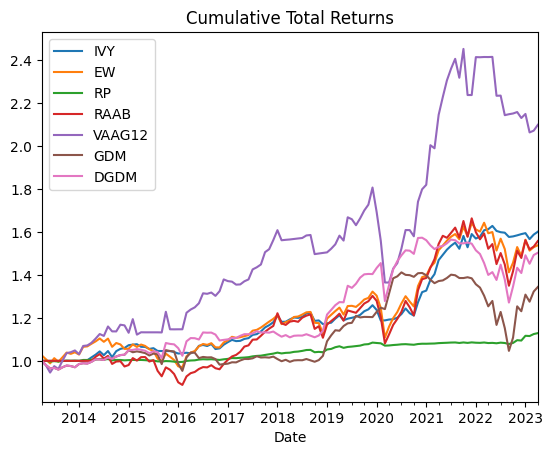

In [185]:
port_total_returns.add(1).cumprod().plot(title="Cumulative Total Returns");

In [193]:
Tearsheet(port_total_returns).summary(ann_factor=12).round(2)

,IVY,EW,RP,RAAB,VAAG12,GDM,DGDM
#obs,121.00,121.00,121.00,121.00,121.00,121.00,121.00
#years,9.99,9.99,9.99,9.99,9.99,9.99,9.99
Total Return,0.60,0.54,0.13,0.56,1.10,0.34,0.50
Annual. Return,0.05,0.04,0.01,0.05,0.08,0.03,0.04
Volatility,0.05,0.09,0.01,0.10,0.12,0.09,0.09
MaxDD,-0.06,-0.16,-0.01,-0.19,-0.25,-0.26,-0.19
Skewness,0.18,-0.74,1.18,-0.36,-0.36,0.60,-0.46
Kurtosis,4.70,5.70,10.98,4.24,5.31,9.13,8.64
Sharpe Ratio,0.94,0.52,0.97,0.48,0.67,0.36,0.50
StdErr,0.32,0.34,0.29,0.33,0.33,0.31,0.33
